# <center>BBC News Classification<center>

## <div style="text-align: right;">----5510 Week 4 Project</div>


## 1. Exploratory Data Analysis

We begin by loading the data and all the necessary packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from collections import Counter

# Load the training and test data
train_df = pd.read_csv('/Users/xinpeiyue/Downloads/learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('/Users/xinpeiyue/Downloads/learn-ai-bbc/BBC News Test.csv')

Next we check the basic information of the data and make some histograms to get a basic idea of its structure.


In [2]:
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


### 1.1. Display the histogram of category distribution

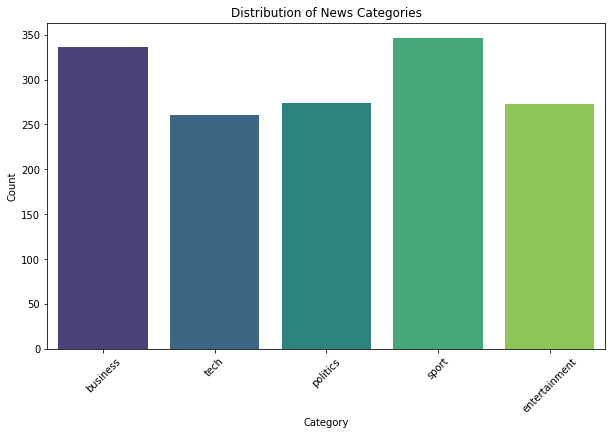

In [6]:
# 1. Histogram of category distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=train_df, palette='viridis')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 1.2. Display the histogram of text length distribution

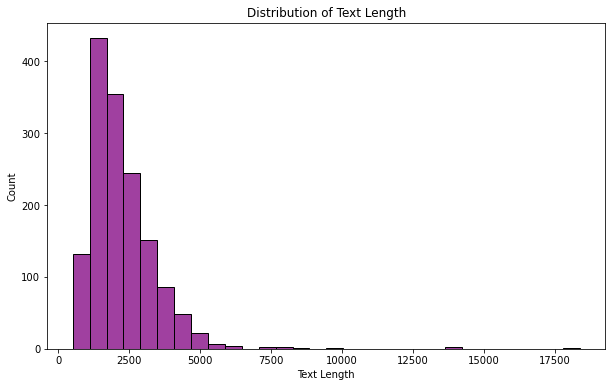

In [7]:
# 2. Histogram of text length distribution
train_df['Text Length'] = train_df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Text Length'], bins=30, color='purple')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

### 1.3. Display the histogram of word count distribution

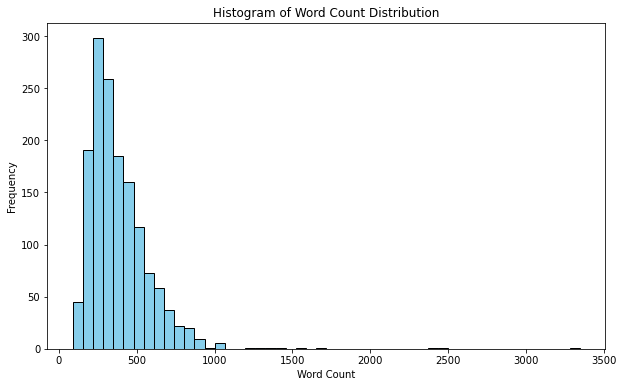

In [8]:
# Calculate the word count for each article
train_df['Word Count'] = train_df['Text'].apply(lambda x: len(x.split()))

# Plot a histogram of the word count distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df['Word Count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### 1.4. Plot the top 20 words by frequency in each category

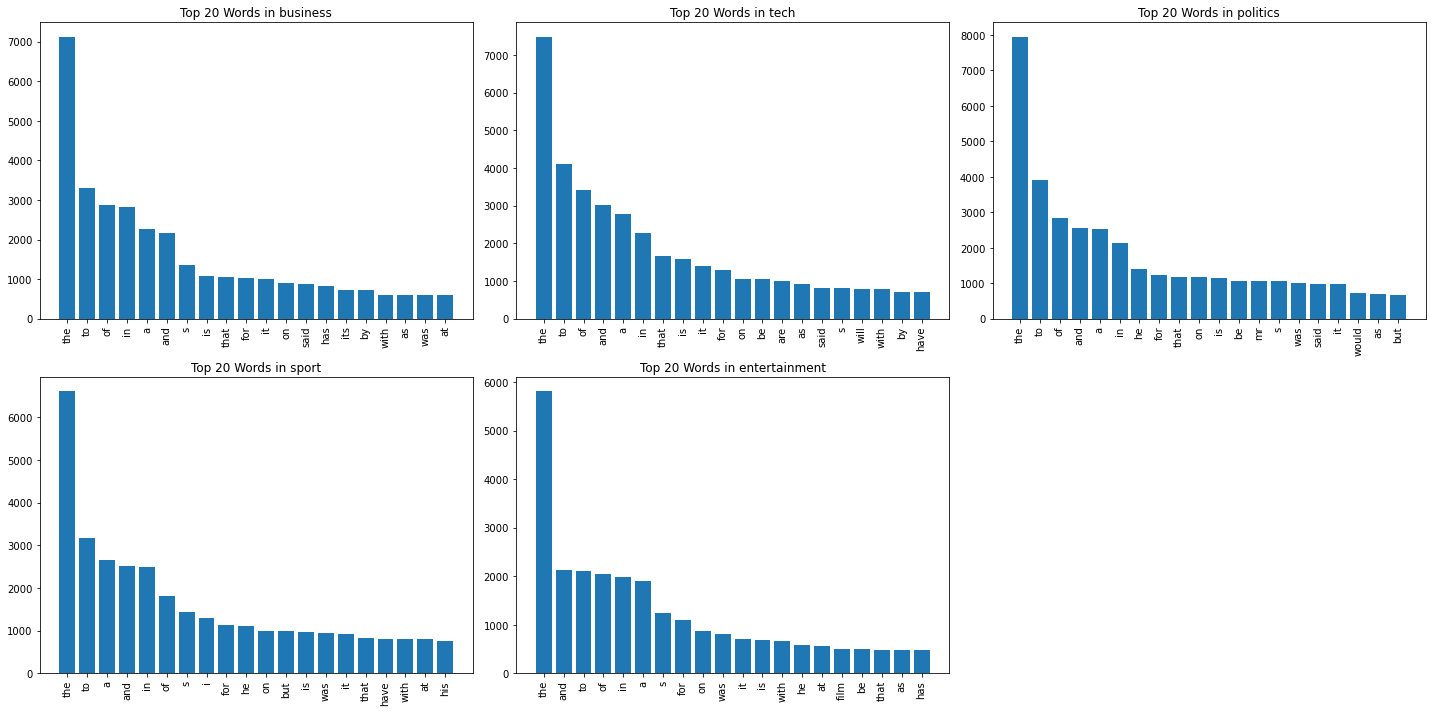

In [9]:
# Tokenize the text and count word frequencies in each category
category_word_counts = {}
for category in train_df['Category'].unique():
    words = ' '.join(train_df[train_df['Category'] == category]['Text']).split()
    word_counts = Counter(words)
    category_word_counts[category] = word_counts

# Plot the top 20 words by frequency in each category
plt.figure(figsize=(20, 10))
for i, (category, word_counts) in enumerate(category_word_counts.items(), 1):
    top_words = word_counts.most_common(20)
    words, frequencies = zip(*top_words)
    plt.subplot(2, 3, i)
    plt.bar(words, frequencies)
    plt.title(f'Top 20 Words in {category}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 2. Data Cleaning

**Convert to lowercase**: Converting all text to lowercase helps ensure that words are treated consistently regardless of their original case. This is important for tasks like text matching, where "Hello" and "hello" should be considered the same word. It also helps in reducing the vocabulary size, as words in different cases would otherwise be treated as different words.

**Remove punctuation**: Punctuation marks such as commas, periods, and exclamation points don't usually carry significant meaning for many text analysis tasks. Removing them can simplify the text and make it easier for algorithms to process. However, in some contexts (like sentiment analysis), certain punctuation marks might convey sentiment and are retained.

In [10]:
# Convert to lowercase and remove punctuation
train_df['Text'] = train_df['Text'].str.lower().str.replace('[^\w\s]', '', regex=True)

## 3. Plan of Analysis based on EDA

Here I will choose TF-IDF as a feature extraction method based on the follwoing factors:

**Sparse Representation**: TF-IDF produces a sparse matrix representation of the text data, which is more memory-efficient and computationally efficient for algorithms like NMF that are designed to work with sparse matrices.

**Interpretability**: TF-IDF assigns weights to words based on their importance in the document and the entire corpus. This weighting scheme helps in identifying the most significant words in each topic, making the results more interpretable.

**Simplicity**: TF-IDF is a simple and well-understood method for text vectorization. It does not require training a separate model, unlike Word2Vec or GloVe, which makes it easier to implement and apply to new datasets.

<module 'matplotlib.pyplot' from '/Users/xinpeiyue/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

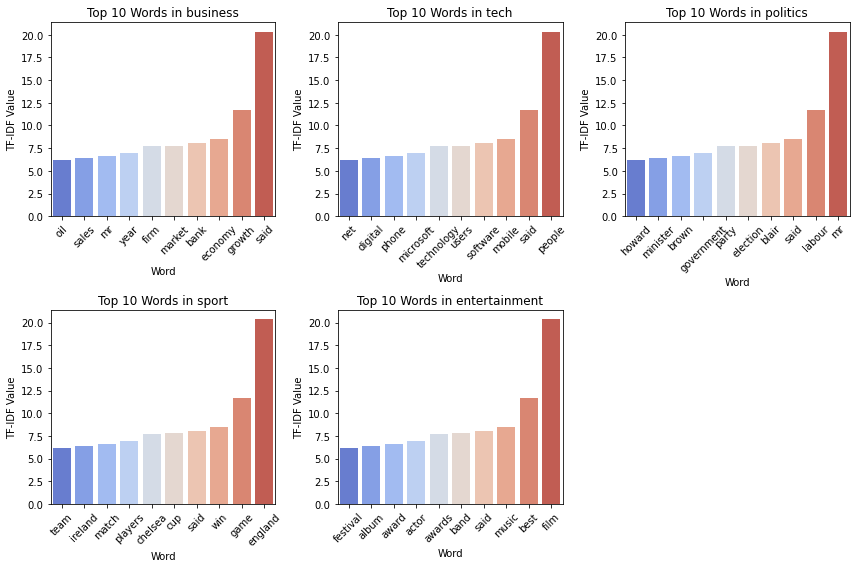

In [11]:
# Plot the top 10 words with highest TF-IDF values in each category
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['Text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 10 words with highest TF-IDF values for each category
top_words = {}
for category in train_df['Category'].unique():
    category_mask = train_df['Category'] == category
    category_tfidf = tfidf_matrix[category_mask].toarray().sum(axis=0)
    top_indices = category_tfidf.argsort()[-10:]
    top_words[category] = [feature_names[i] for i in top_indices]

# Plot the top 10 words for each category
plt.figure(figsize=(12, 8))
for i, (category, words) in enumerate(top_words.items(), 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=words, y=sorted(category_tfidf[top_indices]), palette='coolwarm')
    plt.title(f'Top 10 Words in {category}')
    plt.xlabel('Word')
    plt.ylabel('TF-IDF Value')
    plt.xticks(rotation=45)
plt.tight_layout()
plt

## 4. Matrix Factorization

Here I will use NMF. NMF is often preferred over other matrix factorization methods for topic modeling with TF-IDF due to its non-negativity constraint, which ensures that all values in the factorized matrices are non-negative. This aligns well with TF-IDF data and leads to more interpretable results, as each component of the factorized matrices can be seen as a distinct topic composed of additive combinations of words. NMF's interpretability is a key advantage, making it easier to understand the composition of each topic. Additionally, NMF is well-suited for handling sparse data, such as the sparse matrices produced by TF-IDF, making it computationally efficient for large text corpora. The flexibility in choosing the number of topics and the robustness of NMF in capturing the underlying structure of the data further contribute to its suitability for topic modeling tasks.

In [15]:
tfidf = tfidf_vectorizer.fit_transform(train_df['Text'])

# Apply NMF to factorize the TF-IDF matrix
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=42)
nmf.fit(tfidf)

# Extract topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:]]))
    print()

# Assign topics to documents
topic_distribution = nmf.transform(tfidf)
train_df['Topic'] = topic_distribution.argmax(axis=1) + 1

print("Shape of TF-IDF matrix:", tfidf.shape)

# Display the first few rows with assigned topics
train_df[['Text', 'Topic']].head()


Topic 1:
team play players cup said ireland wales win game england

Topic 2:
howard minister government said party brown election blair labour mr

Topic 3:
microsoft users phones technology digital phone said music people mobile

Topic 4:
oscar films director won actress actor award awards best film

Topic 5:
2004 oil market bank economic year sales said economy growth

Shape of TF-IDF matrix: (1490, 14761)


,Text,Topic
0,worldcom exboss launches defence lawyers defen...,5
1,german business confidence slides german busin...,5
2,bbc poll indicates economic gloom citizens in ...,5
3,lifestyle governs mobile choice faster bett...,3
4,enron bosses in 168m payout eighteen former en...,5


## 5. Hyperparameter Tuning

I will try to use different n_components values{5,6,7,8,9,10} in this process. It affects the model's ability to capture meaningful patterns in the data. Choosing the right value requires balancing between underfitting and overfitting to achieve the best performance.

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# map function
def map_topics_to_categories_cosine_similarity(nmf_components, category_word_distributions, category_names):
    """Maps NMF topics to categories based on cosine similarity of word distributions."""
    topic_word_distributions = nmf_components / nmf_components.sum(axis=1, keepdims=True)
    similarities = cosine_similarity(topic_word_distributions, category_word_distributions)
    mapping = {}
    for topic_idx, category_idx in enumerate(similarities.argmax(axis=1)):
        mapping[topic_idx + 1] = category_names[category_idx]
    return mapping

# Get the category names
category_names = list(train_df['Category'].unique())

# Map NMF topics to actual categories using cosine similarity
#topic_mapping_cosine = map_topics_to_categories_cosine_similarity(nmf.components_, category_word_distributions_matrix, category_names)
#print(topic_mapping_cosine)


   n_components  accuracy
0             5  0.916779
1             6  0.820805
2             7  0.826174
3             8  0.827517
4             9  0.910067
5            10  0.940268


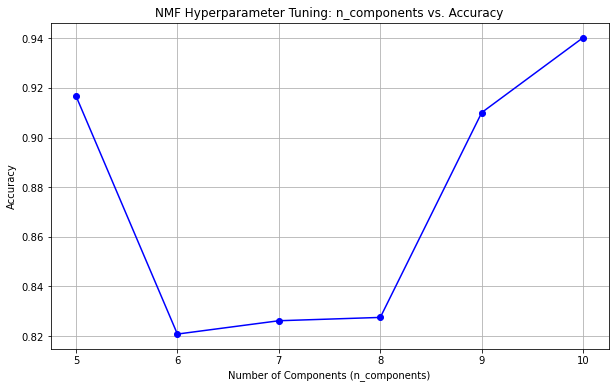

In [19]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(true_categories, predicted_categories):
    """Calculates the accuracy of the predicted categories."""
    return accuracy_score(true_categories, predicted_categories)

# Hyperparameter tuning: Try different values for n_components
n_components_values = [5, 6, 7, 8, 9, 10]
accuracy_results = []

for n_components in n_components_values:
    nmf = NMF(n_components=n_components, init='nndsvd', random_state=42)
    nmf.fit(tfidf)
    
    # Map NMF topics to actual categories using cosine similarity
    topic_mapping = map_topics_to_categories_cosine_similarity(nmf.components_, category_word_distributions_matrix, category_names)
    
    # Assign predicted categories to documents
    topic_distribution = nmf.transform(tfidf)
    predicted_categories = [topic_mapping[topic_idx + 1] for topic_idx in topic_distribution.argmax(axis=1)]
    
    # Calculate accuracy
    accuracy = calculate_accuracy(train_df['Category'], predicted_categories)
    accuracy_results.append({'n_components': n_components, 'accuracy': accuracy})

# Convert results to a DataFrame
accuracy_results_df = pd.DataFrame(accuracy_results)

# Display the results table
print(accuracy_results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(accuracy_results_df['n_components'], accuracy_results_df['accuracy'], marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Accuracy')
plt.title('NMF Hyperparameter Tuning: n_components vs. Accuracy')
plt.grid(True)
plt.show()


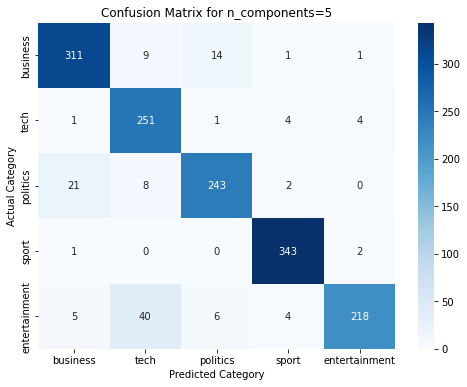

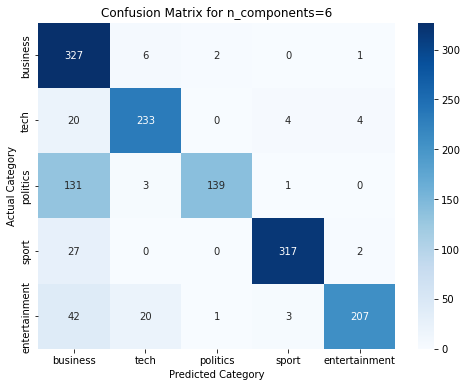

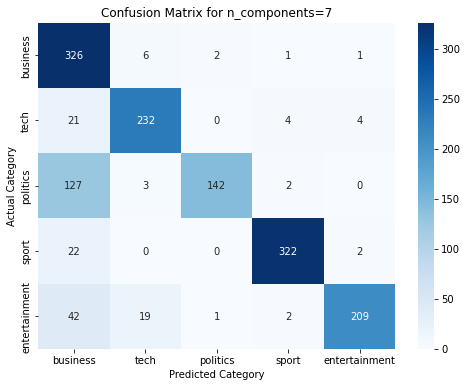

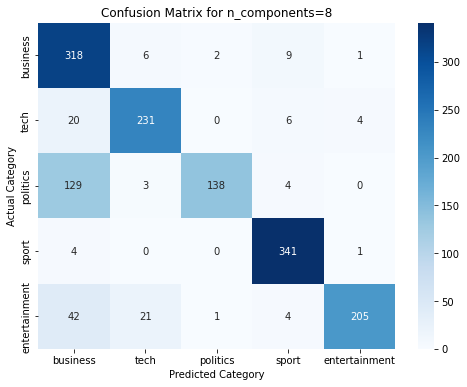

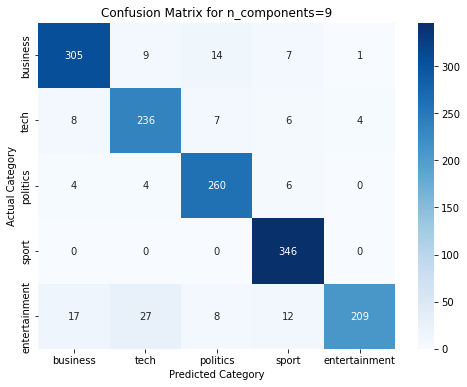

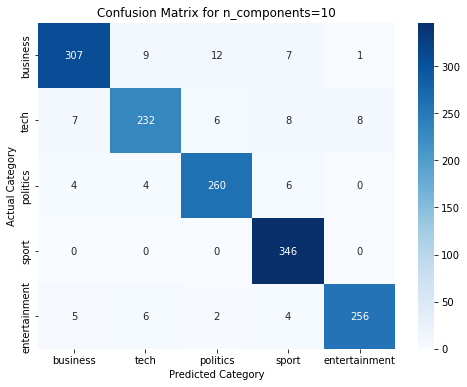

   n_components  accuracy
0             5  0.916779
1             6  0.820805
2             7  0.826174
3             8  0.827517
4             9  0.910067
5            10  0.940268


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calculate_accuracy(true_categories, predicted_categories):
    """Calculates the accuracy of the predicted categories."""
    return accuracy_score(true_categories, predicted_categories)

# Hyperparameter tuning: Try different values for n_components
n_components_values = [5, 6, 7, 8, 9, 10]
accuracy_results = []

# Define the function to calculate word distributions for each category
def calculate_category_word_distributions(df, feature_names):
    category_word_distributions = {}
    for category in df['Category'].unique():
        category_text = ' '.join(df[df['Category'] == category]['Text'])
        category_word_counts = Counter(category_text.split())
        total_count = sum(category_word_counts.values())
        category_word_distributions[category] = np.array([category_word_counts.get(word, 0) / total_count for word in feature_names])
    return np.array(list(category_word_distributions.values())), list(category_word_distributions.keys())

# Calculate word distributions for each category
category_word_distributions_matrix, category_names = calculate_category_word_distributions(train_df, feature_names)

# Hyperparameter tuning with confusion matrix
for n_components in n_components_values:
    nmf = NMF(n_components=n_components, init='nndsvd', random_state=42)
    nmf.fit(tfidf)
    
    # Map NMF topics to actual categories using cosine similarity
    topic_mapping = map_topics_to_categories_cosine_similarity(nmf.components_, category_word_distributions_matrix, category_names)
    
    # Assign predicted categories to documents
    topic_distribution = nmf.transform(tfidf)
    predicted_categories = [topic_mapping[topic_idx + 1] for topic_idx in topic_distribution.argmax(axis=1)]
    
    # Calculate accuracy and confusion matrix
    accuracy = calculate_accuracy(train_df['Category'], predicted_categories)
    conf_matrix = confusion_matrix(train_df['Category'], predicted_categories, labels=category_names)
    
    # Store the results
    accuracy_results.append({'n_components': n_components, 'accuracy': accuracy, 'confusion_matrix': conf_matrix})

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.title(f'Confusion Matrix for n_components={n_components}')
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    plt.show()

# Convert results to a DataFrame
accuracy_results_df= pd.DataFrame(accuracy_results)

# Display the results table
print(accuracy_results_df[['n_components', 'accuracy']].head(6))


From the above graphs and accuracy table we can see that when n_components = 10, our NMF model has the best performance. We will next use n_components = 10 to fit our final NMF model.

Accuracy for NMF.final with n_components=10: 0.9402684563758389
Confusion Matrix for NMF.final with n_components=10:
[[307   9  12   7   1]
 [  7 232   6   8   8]
 [  4   4 260   6   0]
 [  0   0   0 346   0]
 [  5   6   2   4 256]]


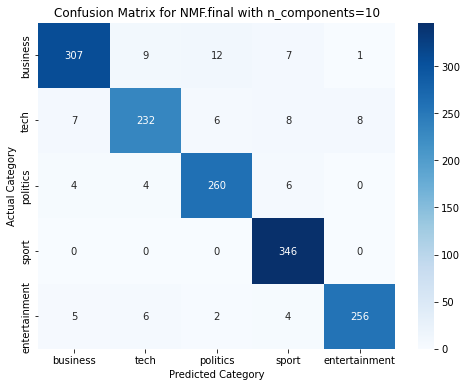

In [20]:
# Apply the final NMF model with n_components = 10
nmf_final = NMF(n_components=10, init='nndsvd', random_state=42)
nmf_final.fit(tfidf)

# Map NMF topics to actual categories using cosine similarity
topic_mapping_final = map_topics_to_categories_cosine_similarity(nmf_final.components_, category_word_distributions_matrix, category_names)

# Assign predicted categories to documents
topic_distribution_final = nmf_final.transform(tfidf)
predicted_categories_final = [topic_mapping_final[topic_idx + 1] for topic_idx in topic_distribution_final.argmax(axis=1)]

# Calculate accuracy and confusion matrix for the final model
accuracy_final = calculate_accuracy(train_df['Category'], predicted_categories_final)
conf_matrix_final = confusion_matrix(train_df['Category'], predicted_categories_final, labels=category_names)

# Print the accuracy and confusion matrix
print(f'Accuracy for NMF.final with n_components=10: {accuracy_final}')
print('Confusion Matrix for NMF.final with n_components=10:')
print(conf_matrix_final)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix for NMF.final with n_components=10')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()


We see that our final NMF model has an accuracy of 0.9402684563758389 on train data. Next, we test its performance on test data.

In [21]:
# Predict categories for the test dataset
test_df['Text'] = test_df['Text'].str.lower().str.replace('[^\w\s]', '', regex=True)
tfidf_test = tfidf_vectorizer.transform(test_df['Text'])
topic_distribution_test = nmf_final.transform(tfidf_test)
test_df['Category'] = [topic_mapping_final[topic_idx + 1] for topic_idx in topic_distribution_test.argmax(axis=1)]
test_df.drop(columns=['Text'], inplace=True)

# Save the resulting dataframe to a new CSV file
test_df.to_csv('NMF test set result.csv', index=False, columns=['ArticleId', 'Category'])

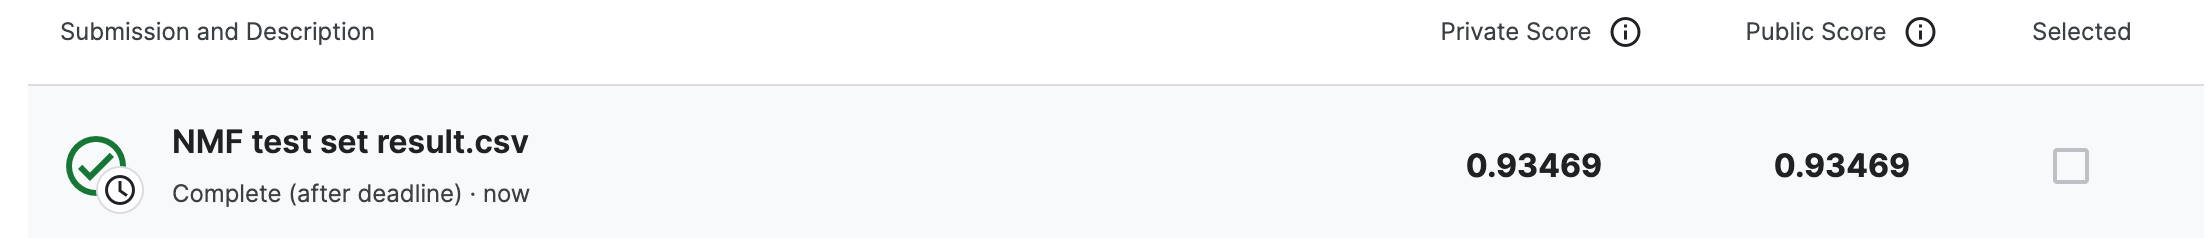

In [23]:
from IPython.display import Image

# Specify the path to image file
image_path = '/Users/xinpeiyue/Downloads/NMF.png'

# Display the image
Image(filename=image_path)


submitted to Kaggle and the score is 0.93469.

## 6. Comparison with Supervised Learning

Here, I will use three supervised learning models and see their train accuracy:

   1.**Multinomial Naive Bayes** with 80% data for training and 20% for testing
    
   2.**Logistic Regression** with 80% data for training and 20% for testing
    
   3.**Logistic Regression** with 50% data for training and 50% for testing
    

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('/Users/xinpeiyue/Downloads/learn-ai-bbc/BBC News Train.csv')

# Split the data into features and target
X = df['Text']
y = df['Category']

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, train_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # Convert text to feature vectors
    vectorizer = CountVectorizer()
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    # Train the model
    model.fit(X_train_vect, y_train)
    
    # Make predictions and evaluate the model
    y_pred = model.predict(X_test_vect)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Train and evaluate the models
nb_accuracy_80 = train_and_evaluate_model(MultinomialNB(), train_size=0.8)
lr_accuracy_80 = train_and_evaluate_model(LogisticRegression(max_iter=1000), train_size=0.8)
lr_accuracy_50 = train_and_evaluate_model(LogisticRegression(max_iter=1000), train_size=0.5)

# Display the results
results = pd.DataFrame({
    'Model': ['Multinomial Naive Bayes (80/20)', 'Logistic Regression (80/20)', 'Logistic Regression (50/50)'],
    'Test Accuracy': [nb_accuracy_80, lr_accuracy_80, lr_accuracy_50]
})

print(results)


                             Model  Test Accuracy
0  Multinomial Naive Bayes (80/20)       0.976510
1      Logistic Regression (80/20)       0.979866
2      Logistic Regression (50/50)       0.959732


Next, I will check their accuracy on test data.

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Load the training and test datasets
train_df = pd.read_csv('/Users/xinpeiyue/Downloads/learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('/Users/xinpeiyue/Downloads/learn-ai-bbc/BBC News Test.csv')

# Split the training data into features and target
X_train = train_df['Text']
y_train = train_df['Category']

# Convert text to feature vectors
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)

# Train the Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Train the Logistic Regression models
lr_model_80 = LogisticRegression(max_iter=1000)
lr_model_80.fit(X_train_vect, y_train)

# For the 50/50 split, we need to re-split the training data
X_train_50, _, y_train_50, _ = train_test_split(X_train, y_train, train_size=0.5, random_state=42)
X_train_vect_50 = vectorizer.transform(X_train_50)  # Use transform instead of fit_transform
lr_model_50 = LogisticRegression(max_iter=1000)
lr_model_50.fit(X_train_vect_50, y_train_50)

# Make predictions on the test dataset
X_test_vect = vectorizer.transform(test_df['Text'])

# Predict with Multinomial Naive Bayes
test_df['Category'] = nb_model.predict(X_test_vect)
#test_df.drop(columns='Text').to_csv('Multinomial Naive Bayes (80-20).csv', index=False)

# Predict with Logistic Regression (80/20 split)
test_df['Category'] = lr_model_80.predict(X_test_vect)
#test_df.drop(columns='Text').to_csv('Logistic Regression (80-20).csv', index=False)

# Predict with Logistic Regression (50/50 split)
test_df['Category'] = lr_model_50.predict(X_test_vect)
#test_df.drop(columns='Text').to_csv('Logistic Regression (50-50).csv', index=False)


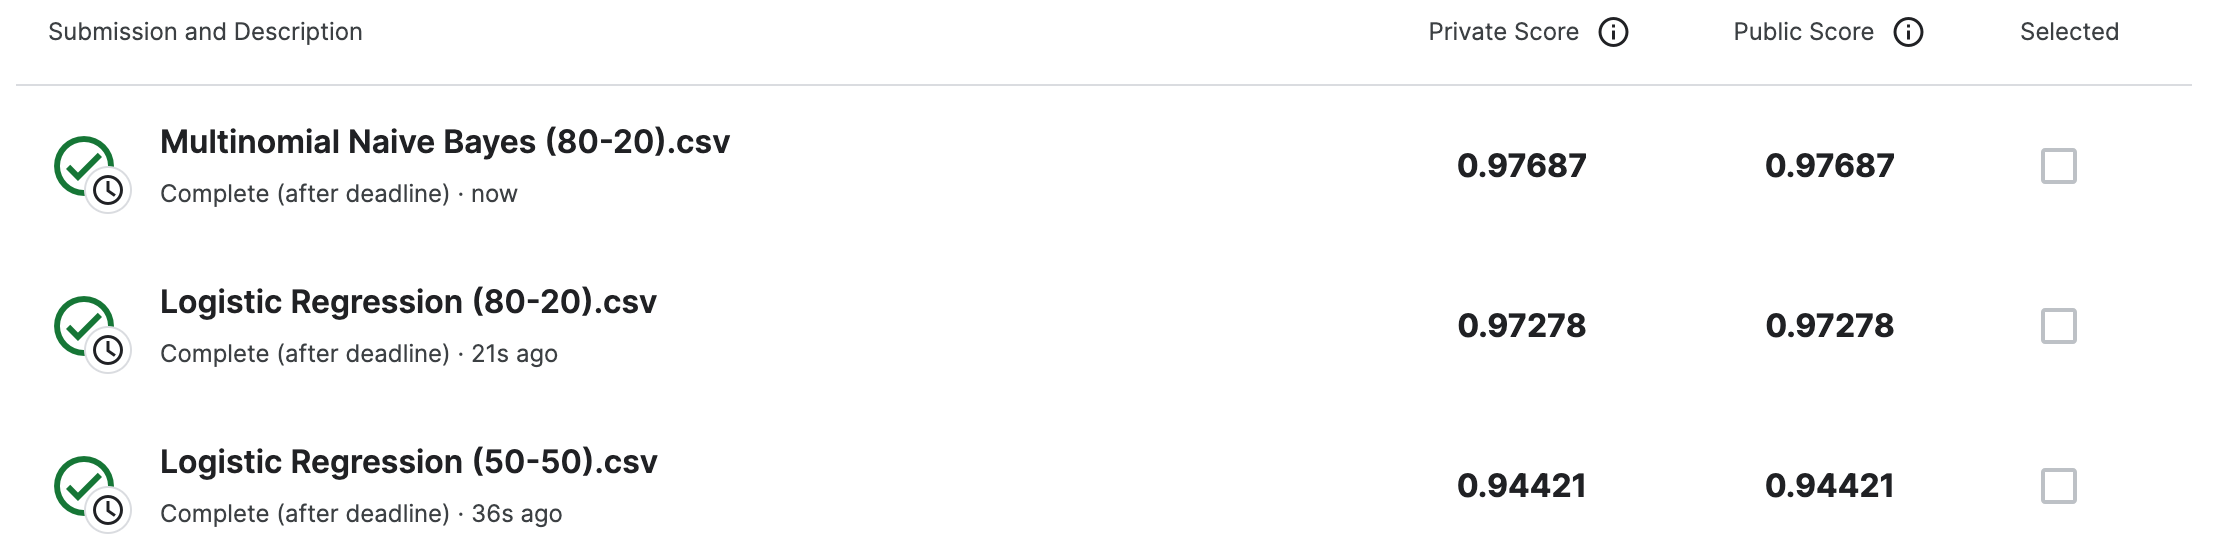

In [28]:
from IPython.display import Image

# Specify the path to image file
image_path = '/Users/xinpeiyue/Downloads/supervised.png'

# Display the image
Image(filename=image_path)

Submitted to Kaggle and the score is shown above.

Finally, I will manually add all the accuracies of different model and put them into one table and do the comparison.

In [29]:
import pandas as pd

# Create the DataFrame
data = {
    "Model": [
        "NMF(n_components = 10)",
        "Multinomial Naive Bayes (0.8 train-0.2 test)",
        "Logistic Regression (0.8 train-0.2 test)",
        "Logistic Regression (0.5 train-0.5 test)"
    ],
    "Train Accuracy": [0.940268, 0.976510, 0.979866, 0.959732],
    "Test Accuracy": [0.93469, 0.97687, 0.97278, 0.94421]
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                          Model  Train Accuracy  Test Accuracy
0                        NMF(n_components = 10)        0.940268        0.93469
1  Multinomial Naive Bayes (0.8 train-0.2 test)        0.976510        0.97687
2      Logistic Regression (0.8 train-0.2 test)        0.979866        0.97278
3      Logistic Regression (0.5 train-0.5 test)        0.959732        0.94421


## 7. Results and Conclusions

From the above table, we can see the train accuracy and test accuracy of each model. And we can compare them in the following aspects:

### Data Efficiency
- **Unsupervised Learning (NMF):** NMF is data-efficient in uncovering hidden structures without needing labeled examples, making it useful for large datasets with unlabeled data.
- **Supervised Learning (Multinomial Naive Bayes, Logistic Regression):** Supervised methods require more labeled data for training. However, they can be very effective at making predictions on new data once trained.

### Performance
- **Unsupervised Learning (NMF):** NMF's performance depends on data complexity and method suitability. It achieved a test accuracy of 93.47% in my project.
- **Supervised Learning (Multinomial Naive Bayes, Logistic Regression):** Supervised methods generally perform better with sufficient labeled data. In my project, Multinomial Naive Bayes and Logistic Regression outperformed NMF with test accuracies of 97.69% and 97.28%, respectively.

### Overfitting
- **Unsupervised Learning (NMF):** NMF is less prone to overfitting compared to supervised methods, especially with an appropriate number of components.
- **Supervised Learning (Multinomial Naive Bayes, Logistic Regression):** Supervised methods are more susceptible to overfitting, particularly with complex models or insufficient training data. Regularization and validation can help mitigate this issue.

## 8. References

https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification 

https://www.kaggle.com/code/akitsuyoshi/text-classification-in-supervised-and-unsupervised 

https://www.kaggle.com/code/mazovi/bbc-news-classification